In [4]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as iio

In [5]:
# set constants
TRAINING_IMAGES_DIR = 'data/images/TRAIN' # directory/path to training images
TEST_IMAGES_DIR = 'data/images/TEST' # directory/path to test images
TRAINING_LABELS_PATH = 'data/labels.csv' # path to training labels csv
IMAGE_HEIGHT = 240 #pixels
IMAGE_WIDTH = 320 #pixels

# dictionaries mapping each label to an integer representation (or vice versa)
REP_TO_LABELS = {0: 'EOSINOPHIL', 1: 'LYMPHOCYTE', 2: 'MONOCYTE', 3: 'NEUTROPHIL'}
LABELS_TO_REP = {'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}

In [6]:
def load_images(dir):
    """
    Loads the images at the directory path dir into an ndarray, then returns it
    with a corresponding list of training labels (from the directory name) and
    the names of the image files.

    Inputs: dir - path to image directory
    Outputs: images = ndarray of size (num images, 240, 320, 3)
             images_names = list of len (num images)
             labels = list of len (num images)
    """
    # create empty lists to store image data
    images_list = [] # ndarrays for the training images
    images_names = [] # the filename of the image
    labels = [] # the true label for the image

    # loop through directory:
    for dirpath, dirnames, filenames in os.walk(dir):
        for file in filenames:
            images_list.append(iio.imread(uri = os.path.join(dirpath, file)).astype(np.uint8))
            images_names.append(file)
            # assign the image a rep based on the directory it lies in
            labels.append(LABELS_TO_REP[Path(dirpath).stem])

    # stack all images into one array and normalize values to [0,1]
    images = np.stack(images_list, axis=0)/255

    return images, images_names, labels

In [7]:
# load training images and labels
train_images, train_images_names, train_labels = load_images(TRAINING_IMAGES_DIR)

MemoryError: Unable to allocate 17.1 GiB for an array with shape (9957, 240, 320, 3) and data type float64

In [8]:
# load test images and labels
# test_images, test_images_names, test_labels = load_images(TEST_IMAGES_DIR)

def load_images(dir, batch_size=32):
    """
    Generator that yields batches of images and labels as ndarrays.

    Inputs: dir - path to image directory
            batch_size - number of images per batch
    Outputs: images = ndarray of size (batch_size, 240, 320, 3)
             labels = ndarray of size (batch_size,)
    """
    # create empty lists to store image data
    images_list = [] # ndarrays for the training images
    labels = [] # the true label for the image

    # loop through directory:
    for dirpath, dirnames, filenames in os.walk(dir):
        for file in filenames:
            images_list.append(iio.imread(uri = os.path.join(dirpath, file)).astype(np.uint8))
            # assign the image a rep based on the directory it lies in
            labels.append(LABELS_TO_REP[Path(dirpath).stem])

            if len(images_list) == batch_size:
                # stack all images into one array and normalize values to [0,1]
                images = np.stack(images_list, axis=0)/255
                yield images, np.array(labels)

                # clear the lists for the next batch
                images_list = []
                labels = []

    # yield the last batch if it's smaller than batch_size
    if images_list:
        images = np.stack(images_list, axis=0)/255
        yield images, np.array(labels)


NameError: name 'train_images' is not defined

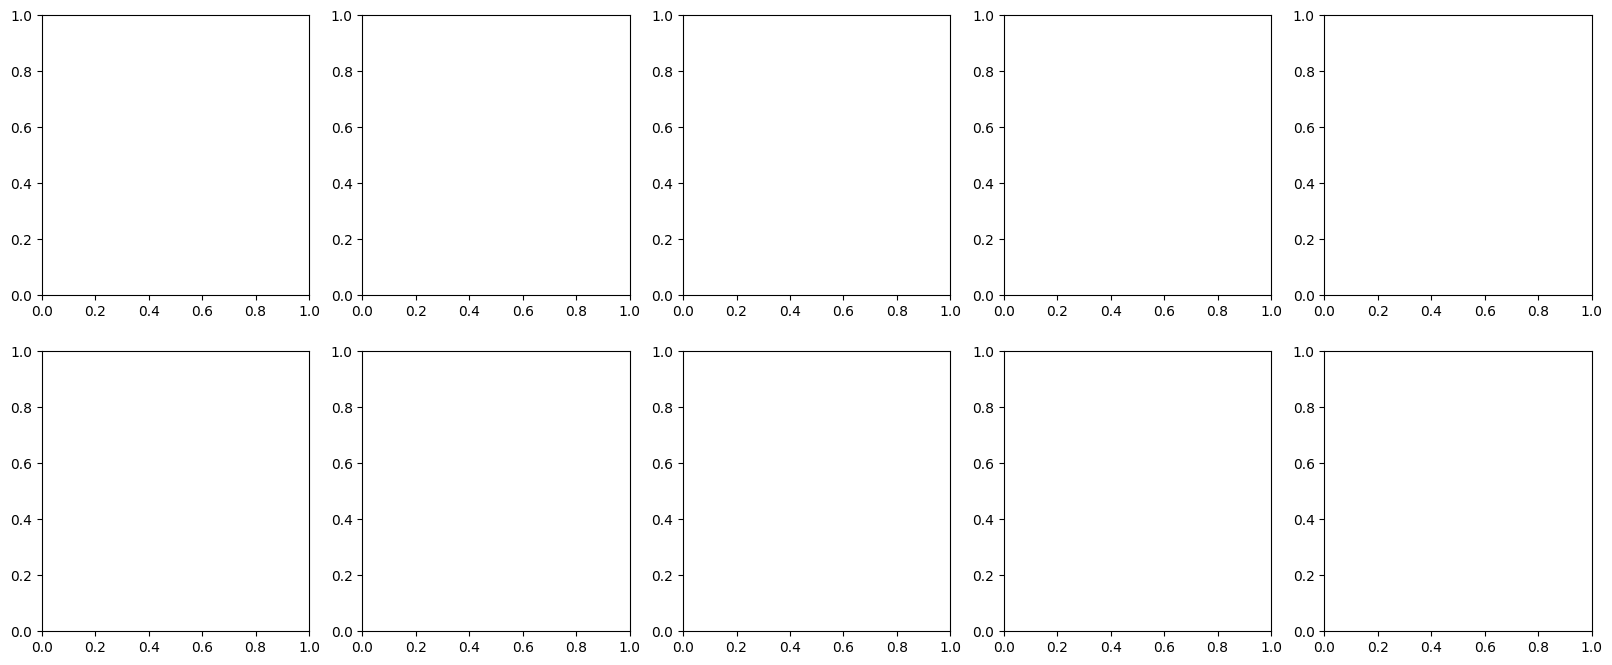

In [9]:
# display 10 cell images
fig, axs = plt.subplots(2, 5, figsize=(20,8))
count = 0
for i in range(2):
    for j in range(5):
        axs[i,j].imshow(train_images[850*count,:,:,:].reshape([IMAGE_HEIGHT,IMAGE_WIDTH,3]))
        # axs[i,j].axis("off")
        axs[i,j].set_xlabel(REP_TO_LABELS[train_labels[850*count]])
        count+=1
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, Add, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model

# input layer
inputs = tf.keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

# Standard structure of convolutional layers followed by max pooling layers
x = Conv2D(32, (3,3), activation='relu')(inputs)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation = 'relu')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(128, (3,3), activation = 'relu')(x)
x = MaxPooling2D((2,2))(x)

# 1x1 convolution to reduce complexity and also to be part of the MobileNet
x = Conv2D(32, (1, 1), activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# depthwise separable convolution (from MobileNet)
x = DepthwiseConv2D((3, 3), activation='relu')(x)
x = Conv2D(64, (1, 1), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

# additional convolutional layer
x = Conv2D(128, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

# residual connection (from ResNet)
residual = Conv2D(128, (1, 1), strides=(2, 2))(x)
x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(128, (3, 3), padding='same')(x)
x = Add()([x, residual])
x = tf.keras.activations.relu(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# flatten and dense layers
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
outputs = Dense(len(REP_TO_LABELS), activation='softmax')(x)

# create the model
model_built = Model(inputs=inputs, outputs=outputs)

# compile the model
model_built.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# train the model
model_built.fit(train_images, train_labels, epochs=10, validation_split=0.2)